In [1]:
import os, glob, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE
from scipy.stats import pearsonr
import string
from skimage import measure

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import rasterio  as rio
from datetime import datetime

import cv2
from tqdm import tqdm
from multiprocessing import Pool

from visualize_results import psd2im, draw_subplots
from network import GNPF

/projappl/project_2002668/miniconda3/envs/dl/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# random seed
SEED = 233

In [4]:
def savefig(fig, savepath, savename, fmt='png', dpi=600, savepdf=True):
    """
    save figure to desired folder (savepath) with a specific name (savename)

    Parameters:
        fig            -- the top level container for all the plot elements
        savepath (str) -- file path to save the figure
        savename (str) -- name to be saved for the figure
        fmt (str)      -- file format to be saved
        dpi (str)      -- dpi for the figure to be saved
        savepdf (bool) -- sometimes the pdf format is not necessary
    
    Returns:
        None
    """

    # create a new folder if not exists
    os.makedirs(f'{savepath}', exist_ok=True)

    # save the figure
    fig.savefig(os.path.join(savepath, f'{savename}.{fmt}'), dpi=dpi, bbox_inches='tight', pad_inches=0)

    # save the pdf version
    if (fmt != 'pdf') and (savepdf):
        fig.savefig(os.path.join(savepath, f'{savename}.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

# Figure 1 -- study area

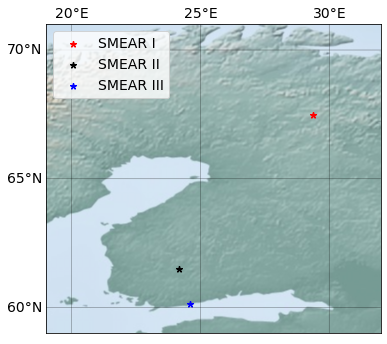

In [5]:
ftsize = 14
plt.rcParams.update({'font.size': ftsize})

fig, ax = plt.subplots(figsize=(6, 6))

# FI
# fig, ax = plt.subplots(figsize=(5, 16))
m = Basemap(llcrnrlon=19, llcrnrlat=59, urcrnrlon=32, urcrnrlat=71,
               epsg=4326, lat_1=30, lat_2=45, lon_0=105, resolution='h', ax=ax)
    
# add the longitudes and latitudes
parallels = np.arange(55., 75, 5.)  # latitude
m.drawparallels(parallels, labels=[True, False, True, False], linewidth=0.5)
meridians = np.arange(15., 35, 5.) # longitude
m.drawmeridians(meridians, labels=[True, False, True, False], linewidth=0.5)

# add border
# m.readshapefile(f"datasets/topo/FI", 'FI', linewidth=1)

lats, lons = m([29.36, 24.17, 24.58], [67.46, 61.51, 60.12])
labels = ['SMEAR I', 'SMEAR II', 'SMEAR III']
colors = ['r', 'k', 'b']
for idx, (lat, lon) in enumerate(zip(lats, lons)):
    m.scatter(lat, lon,
            s = 30,
            label=labels[idx],
            c=colors[idx],
            rasterized=True,
            marker=(5,2)
            )
ax.set_rasterization_zorder(1)
ax.legend(loc=2)
m.shadedrelief()
savefig(fig, 'figures', 'station_loc')

# Figure 2 -- surface plots of measured PNSD

In [6]:
df_var = pd.read_csv('datasets/var.csv', parse_dates=[0], index_col=0).iloc[:, 9:]
df_hyy = pd.read_csv('datasets/hyy.csv', parse_dates=[0], index_col=0).iloc[:, 9:]
df_kum = pd.read_csv('datasets/kum.csv', parse_dates=[0], index_col=0).iloc[:, 9:]
print(df_var.shape, df_hyy.shape, df_kum.shape)

(1177699, 52) (1211656, 52) (878997, 52)


In [7]:
days_var = sorted(np.unique(df_var.index.date.astype(str)).tolist())
days_hyy = sorted(np.unique(df_hyy.index.date.astype(str)).tolist())
days_kum = sorted(np.unique(df_kum.index.date.astype(str)).tolist())

In [8]:
def get_random_pnsd(df):
    days = sorted(np.unique(df.index.date.astype(str)).tolist())

    # store the results to res
    res = []
    name = []
    while len(res) != 4:
        days_selected = np.random.choice(days, 4)
        for day in days_selected:
            if df.loc[str(day)].shape != (144, 52):
                continue
        res = [df.loc[str(day)] for day in days_selected]
    
    return res

In [86]:
# np.random.seed(SEED)
dfs = get_random_pnsd(df_var) + get_random_pnsd(df_hyy) + get_random_pnsd(df_kum)
names = [df.index.date.astype(str)[0] for df in dfs]

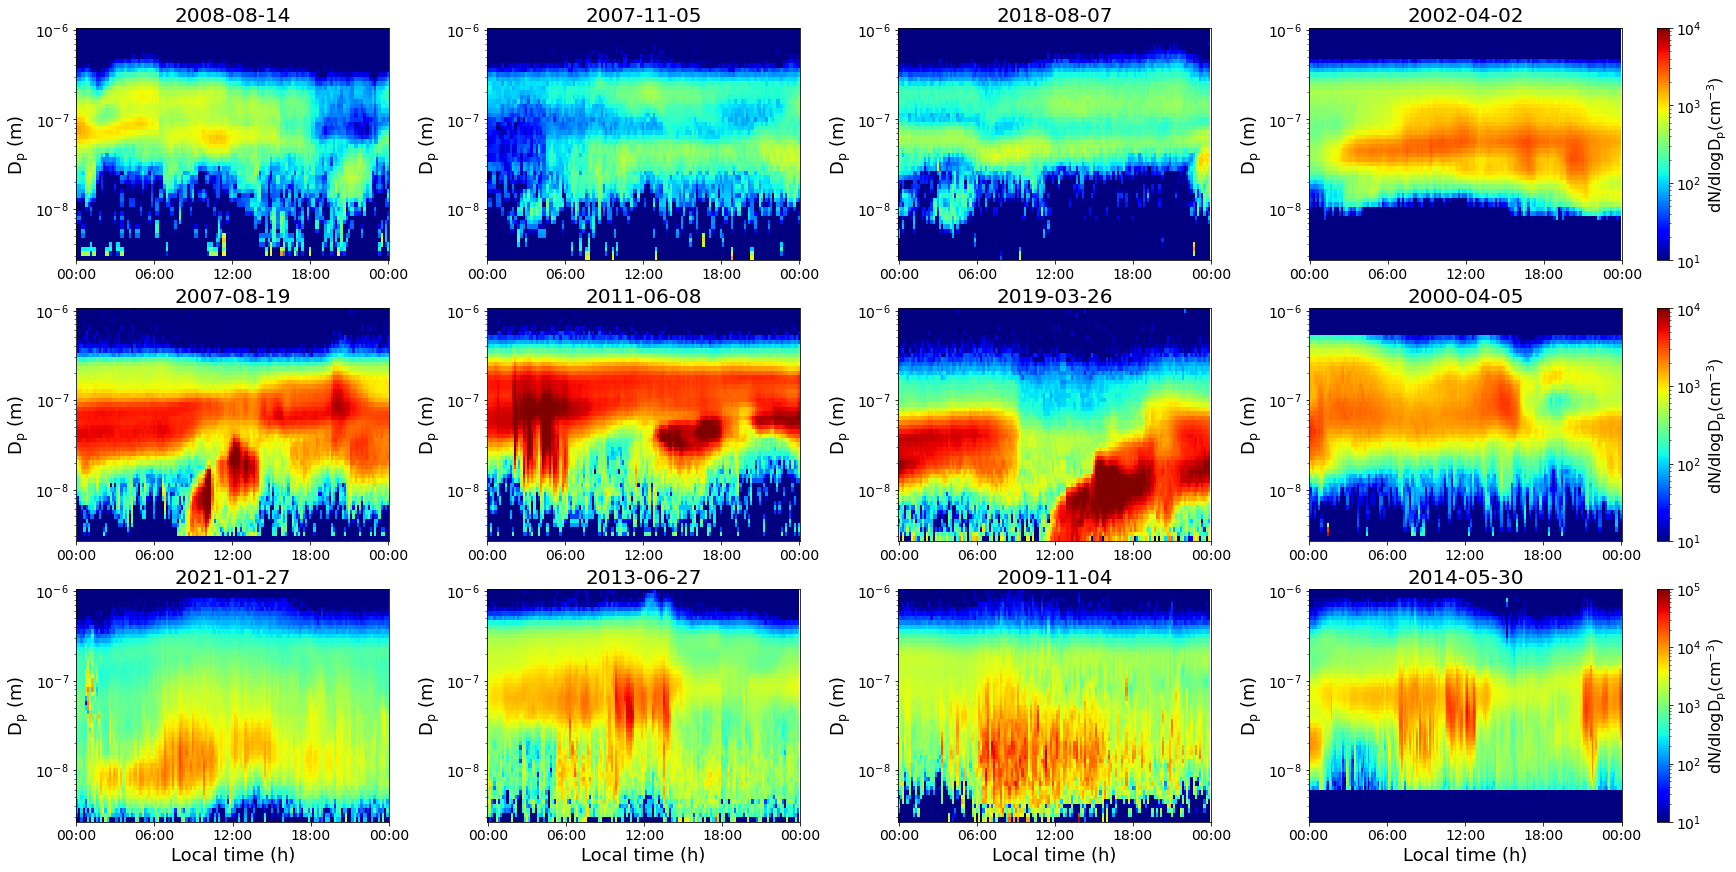

In [87]:
draw_subplots(dfs, names=names, nrows=3, ncols=4, 
    cbar='multirow', vmaxs=[1e4, 1e4, 1e5], use_title=True, savefp='figures', savename='real_pnsd')

# Figure 4 -- surface plots of generated PNSD for SMEAR I

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataframe with template time points and particle size slots
df_temp = pd.read_csv('template.csv', parse_dates=[0], index_col=0)

In [10]:
# load the pre-trained model
net = GNPF()
epoch = 20
net.load_state_dict(torch.load(f'checkpoints/var/G_{epoch}.pth', map_location=device))
net.eval()

None

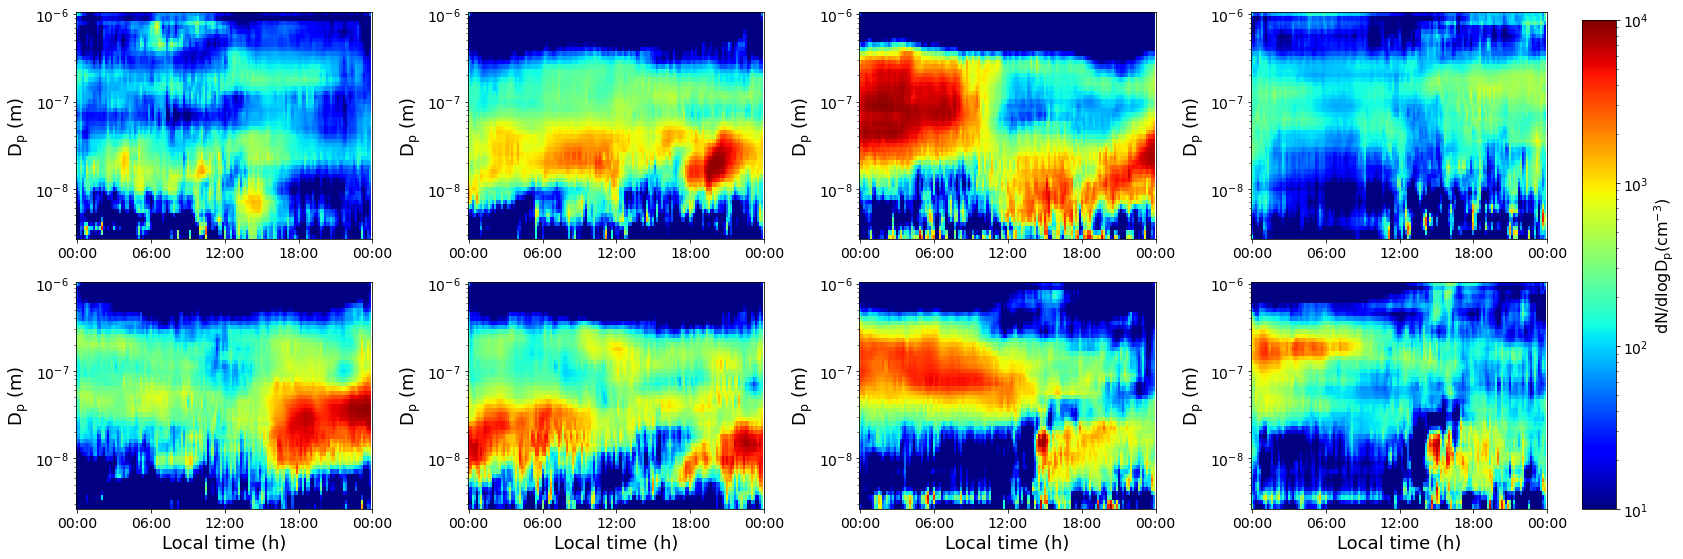

In [11]:
n = 8
vmax = 1e4
with torch.no_grad():
    torch.manual_seed(SEED)
    x = torch.randn(n, 100, 1, 1)
    y = net(x).squeeze().cpu().numpy() * vmax
    dfs = [pd.DataFrame(y_, index=df_temp.index, columns=df_temp.columns) for y_ in y]
    draw_subplots(dfs, names=['']*n, nrows=2, ncols=4, savefp='figures', vmaxs=[vmax]*n, savename='var')

# Figure 7 -- vector arithmetic for SMEAR I

In [12]:
torch.manual_seed(SEED)
for _ in range(5):
    seeds = torch.randint(0, 10000, (2,))
    seed1 = seeds[0]
    seed2 = seeds[1]

    torch.manual_seed(seed1)
    z1 = torch.randn(1, 100, 1, 1)
    torch.manual_seed(seed2)
    z2 = torch.randn(1, 100, 1, 1)

    dfs = []
    with torch.no_grad():
        for theta in np.linspace(0, 1, 12):
            # theta /= 10
            z = (1 - theta) * z1 + theta * z2
            y = net(z).squeeze().cpu().numpy() * vmax
            df = pd.DataFrame(y, index=df_temp.index, columns=df_temp.columns)
            dfs.append(df)
    draw_subplots(dfs, names=['']*len(dfs), nrows=2, ncols=6, savefp='figures/var', vmaxs=[vmax]*len(dfs), savename=f'{seed1}-{seed2}')
    plt.close()
    plt.clf()


<Figure size 432x288 with 0 Axes>

# Figure 5 -- surface plots of generated PNSD for SMEAR II

In [13]:
# load the pre-trained model
net = GNPF()
epoch = 20
net.load_state_dict(torch.load(f'checkpoints/hyy/G_{epoch}.pth', map_location=device))
net.eval()

None

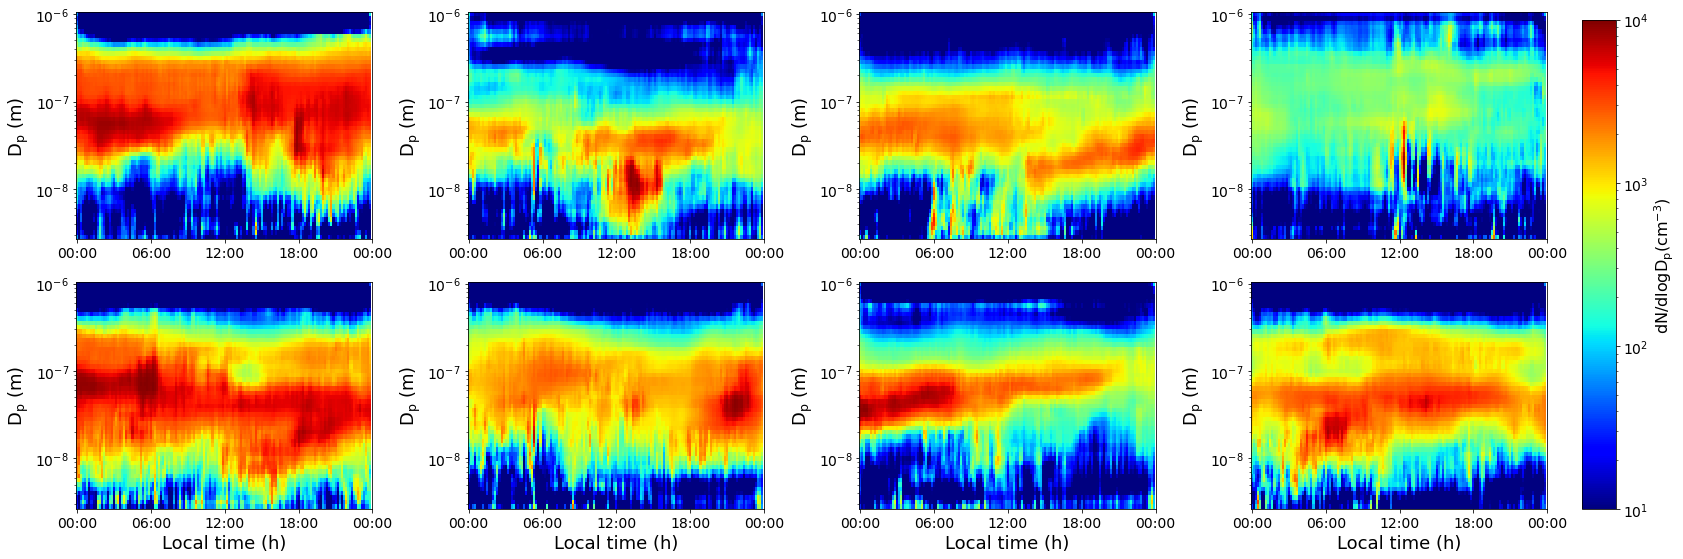

In [14]:
n = 8
vmax = 1e4
with torch.no_grad():
    torch.manual_seed(SEED)
    x = torch.randn(n, 100, 1, 1)
    y = net(x).squeeze().cpu().numpy() * vmax
    dfs = [pd.DataFrame(y_, index=df_temp.index, columns=df_temp.columns) for y_ in y]
    draw_subplots(dfs, names=['']*n, nrows=2, ncols=4, savefp='figures', vmaxs=[vmax]*n, savename='hyy')

# Figure 6 -- surface plots of generated PNSD for SMEAR III

In [15]:
# load the pre-trained model
net = GNPF()
epoch = 20
net.load_state_dict(torch.load(f'checkpoints/kum/G_{epoch}.pth', map_location=device))
net.eval()

None

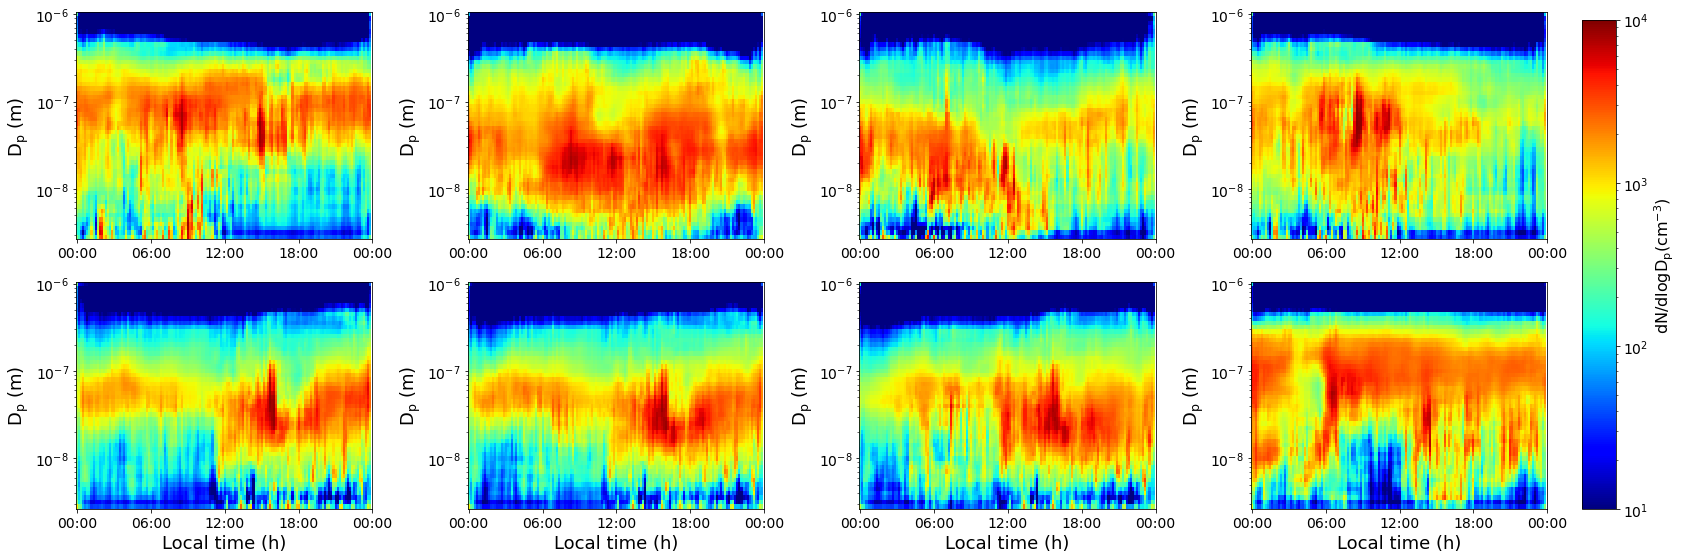

In [16]:
n = 8
vmax = 1e4
with torch.no_grad():
    torch.manual_seed(SEED)
    x = torch.randn(n, 100, 1, 1)
    y = net(x).squeeze().cpu().numpy() * vmax
    dfs = [pd.DataFrame(y_, index=df_temp.index, columns=df_temp.columns) for y_ in y]
    draw_subplots(dfs, names=['']*n, nrows=2, ncols=4, savefp='figures', vmaxs=[vmax]*n, savename='kum')

Figure 8 and Figure 9 are similar to Figure 7.

If you are interested to generate more samples from the generative models, you can use the code below.

In [8]:
# generate as many samples as possible
# taking the generative model for SMEAR I as an example

# use the code below to only save the figures instead of displaying them
############################
# import matplotlib
# matplotlib.use('Agg')
###########################

station = 'var'
vmax = 1e4
net = GNPF()
epoch = 20
net.load_state_dict(torch.load(f'checkpoints/{station}/G_{epoch}.pth', map_location=device))
net.eval()

os.makedirs(f'figures/{station}/PNSD', exist_ok=True)
# increase the num_seed to 1e9, you will obtain 1e9 PNSD samples
num_seed = 1
with torch.no_grad():
    for seed in range(num_seed):
        torch.manual_seed(seed)
        x = torch.randn(1, 100, 1, 1)
        y = net(x).squeeze().cpu().numpy() * vmax
        df = pd.DataFrame(y, index=df_temp.index, columns=df_temp.columns)
        psd2im(df, show_figure=False, savefp=f'figures/{station}/PNSD', vmax=vmax, index=f'{seed}', figsize=(6, 2.5), use_cbar=True)
        plt.clf()
        plt.close()